# Sequential Processing 

So far, we have always processed the entire received signal as a single block of samples.

In practice, samples must be processed *sequentially* as they are received.

Otherwise, 
* the receiver incurs long (or even unbounded) delay (latency),
* the ability to store samples may be exceeded.

We will investigate how we can implement receiver functions that work incrementally as blocks of one or a few samples are received.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/075_sequential_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/075_sequential_processing.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")


In [2]:
## import needed functions from the comms library
from comms.sources import random_symbols, MPE_decision_rule
from comms.pulse_shaping import srrc_pulse, pulse_shape
from comms.sequences import lfsr
from comms.pll import First_Order_Filter, Second_Order_Filter, Integrator, rotate_phase, measure_phase, scale_amplitude, measure_amplitude_error

## Make a test signal

For testing, we construct a signal that consists of:
* two consecutive bursts, separated by an idle period
* Each burst contains:
  + a preamble with known training sequence
    - of length $K=31$ BPSK symbols
    - it is an order-5 M-sequence with feedback `fb=5`
  + a payload that contains
    - 128 QPSK symbols

In [29]:
## Transmitter
# make L bursts containing preamble and payloads
# Parameters
fsT = 32    # tx oversampling
K = 31      # length of preamble
Ns = 128    # length of payload
fb = 5      # LFSR feedback
L = 2       # number of bursts to generate

Ap = np.array([1.0, -1.0], dtype=complex) # BPSK for preamble
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK for payload

hh = srrc_pulse(0.5, fsT)    # pulse shape

# make a single preamble ...
pn = Ap[lfsr(1, fb, K, 5)]
# ... and L distinct payloads
tx_syms = np.zeros((L, Ns), dtype=complex)
for n in range(L):
    tx_syms[n, :] = random_symbols(A, Ns)

# generate the L pulse shaped bursts
N_burst = (K + Ns) * fsT + len(hh) - fsT   # length of pulse shaped signals
sigs = np.zeros((L, N_burst), dtype=complex)
for n in range(L):
    sigs[n,:] = pulse_shape(np.concatenate((pn, tx_syms[n,:])), hh, fsT)

In [30]:
## Channel
# channel parameters
ds_factor = 4       # down-sample by 4

# one set of parameters for each burst
delay_samples = np.array([102, 145])
# frequency offset per symbol period, phase change is +/- 0.1*2*pi over course of preamble
df = 0.1/(fsT*(K-1)) * np.array([1, -1])
# amplitude and phase
X = 0.5*np.exp(1j*np.pi/4) * np.array([1, 1j])

# construct the noise-free received signal; concatenate zeros and sigs
rr = np.concatenate(( np.zeros(delay_samples[0]), 
                     X[0] * sigs[0,:] * np.exp(2j * np.pi * df[0] * np.arange(sigs.shape[1])) ))

for n in range(1, L):
    rr = np.concatenate((rr, 
                         np.zeros(delay_samples[n]), 
                         X[n] * sigs[n,:] * np.exp(2j * np.pi * df[n] * np.arange(sigs.shape[1])) ))

# append a few more zero samples, just so that the signal doesn't end on a signal boundary
rr = np.concatenate((rr, np.zeros(167)))

# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = abs(X[0])**2 / SNR 

# the down-sampled signal should have higher amplitude  
rr = (np.sqrt(ds_factor)*rr + 
      np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))))

Let's look at the signal in time and frequency domains to make sure that it looks good.

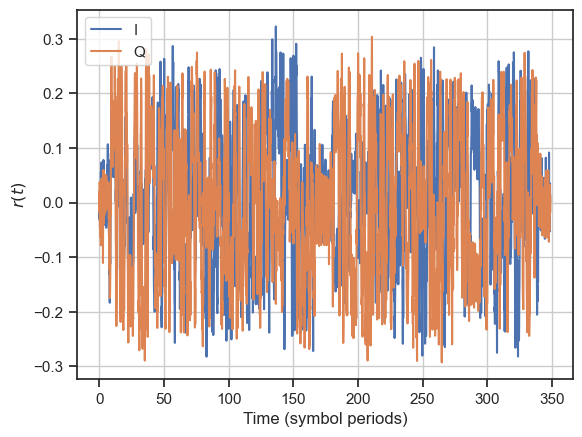

In [31]:
## time domain plot
plt.plot(np.arange(len(rr))/fsT_r, np.real(rr), label='I')
plt.plot(np.arange(len(rr))/fsT_r, np.imag(rr), label='Q')

plt.xlabel('Time (symbol periods)')
plt.ylabel('$r(t)$')
plt.grid()
plt.legend()

plt.show()

There are two distinct burst, each spanning approximately 160 symbol periods.

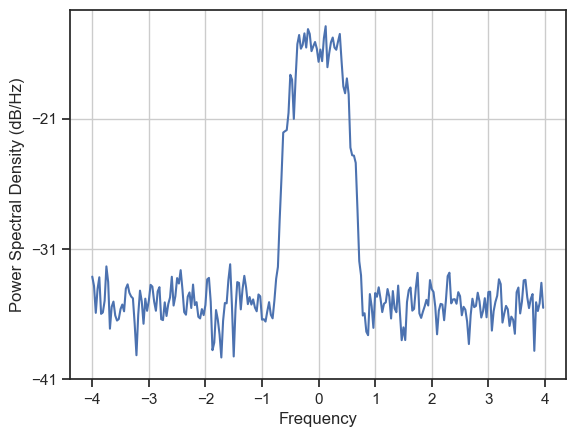

In [32]:
plt.psd(rr, Fs=fsT_r)

plt.show()

The signal occupies between $1/8$ and $1/4$ of the observed band. That is correct as the signal is $8$ times oversampled and the roll-of factor of the filter is 0.5 (50%). 

## Sequential processing

Our goal is to process the signal `rr` in small blocks - possibly as small as a single sample. That is trivial when the operation to be performed is *stateless* or *pure*. 

### Pure functions
Pure functions have no *side-effects*; given the same input, they always produce the same output.

An example of a pure function is the absolute value of each sample. We can easily write a function that computes the expected value.

In [33]:
def my_abs(sig):
    "compute the absolute value of each sample"
    # we could do a loop here, but this is easier
    return np.abs(sig)

We can use this function to process the signal `rr` sequentially one sample at a time:

In [34]:
out = np.zeros_like(rr, dtype=float)
for n in range(len(rr)):
    out[n] = my_abs(rr[n])

### Stateful functions

In contrast to pure functions, *stateful* functions depend on something beyond the input signal. Often, this is a prior input or output. But, it may also be the state of a finite-state machine that controls how a system works.

#### Computing the maximum of a signal sequentially

A simple example of a stateful function is computing the maximum value of the (absolute value of the) input signal. The maximum value depends on all samples, not just the current sample.

There are two ways to write a a stateful, sequential function:
1. passing state to and from the function
2. encapsulate the function in a class

We illustrate both approaches, starting with the former.

In [35]:
def my_max(sig, prior_max=-np.Infinity):
    "compute the maximum sequentially"
    tmp = np.max(np.abs(sig)) # max in this block
    
    # return the greater of prior_max and max in this block
    return max(prior_max, tmp)

We can pass a sample of `rr` at a time to `my_max`, but we **must maintain state** outside the function. the variable max_val does that. 

In [36]:
max_val = -np.Infinity

for n in range(len(rr)):
    max_val = my_max(rr[n], max_val)

assert max_val == np.max(np.abs(rr))
print('OK')

OK


The alternative to maintaining state **outside** a function is to *encapsulate* state inside an object. With this approach, we need to define a `class`.

In [37]:
class c_max():
    "compute maximum of a signal sequentially"

    def __init__(self):
        "Constructor: initially the state"
        # self refers to the object that holds the state
        self.prior_max = -np.Infinity

    def update(self, sig):
        "update the maximum using samples in sig"
        tmp = np.max(np.abs(sig)) # max in this block

        if tmp > self.prior_max:
            self.prior_max = tmp

        # optionally, we can return the max seen so far
        return self.prior_max

To use this class, we 
* first instantiate the object
* then, pass blocks of samples to the `update` method of the object
* finally, we retrieve the maximum

In [38]:
# instantiate the object, using the name of the class; this calls the constructor
obj_max = c_max()

# pass one sample at a time
for n in range(len(rr)):
    obj_max.update(rr[n])  # ignore the return value

# retrieve the maximum
max_val = obj_max.prior_max

assert max_val == np.max(np.abs(rr))
print('OK')

OK


Either method works.
* Using a function, often requires slightly less code as there is no "overhead" for writing a constructor
* Using a class, moves the state variable into the class and hides it from the main flow of the logic.

Let's turn to another example: convolution.

#### Computing convolution sequentially

Convolution is a fundamental signal processing observation. Given and input signal $x[n]$ of length $N$ and an impulse response $h[n]$ of length $M$, the result of the convolution $y[n] = x[n] \ast h[n]$ is
$$
y[n] = \sum_{k=0}^{M-1}  h[k] \cdot x[n-k] \text{, for $0 \leq n < N+K-1$.}
$$

To compute the $n$-th output $y[n]$, we need the samples of the impulse response and samples of the input signal $x[n]$ for $n-M  < n \leq n$.
Put differently, to compute the $n$-th output, we need the $n$-th input as well as the $M-1$ prior inputs.

These $M-1$ prior inputs constitute the state that must be maintained by the stateful implementation. A vector holding these values is sometimes called a *shift register*.

Thus, a stateful implementation must do the following when presented with the $n$-th input $x[n]$:
1. use the state vector $\vec{s}[n] = \left[ x[n-M-1], \ldots, x[n-1] \right]$ and the new sample $x[n]$ to form the vector $\vec{x}[n]=\left[ x[n-M-1], \ldots, x[n-1], x[n] \right]$.
2. use the time-reversed (flipped) impulse response $\vec{h}=\left[ h[M-1, \ldots, h[0] \right]$, to compute the inner product $y[n] = \langle \vec{x}[n], \vec{h} \rangle $
3. update the state vector to $\vec{s}[n+1] = \left[ x[n-M-2], \ldots, x[n] \right]$, i.e., shift the contents of the shift register one position to the left (dropping the oldest sample) and insert the newest sample on the right.

Repeat the above for all input samples.


#### You do it:

Write both a function and a class to implement stateful convolution. The skeletons below should help you get started.

Use the two *Test* cells to check your work.

In [39]:
def my_convolve(xx, hh, shift_reg):
    """sequential convolution function"""
    ## this implementation follows the procedure described above directly

    # allocate storage for y[n]
    yy = np.zeros_like(xx)

    for n in range(len(xx)):
        # concatenate shift_reg and sample x[n]
        sr = np.concatenate((shift_reg, [xx[n]]))
        
        # compute inner product and store in y[n]
        yy[n] = np.inner(sr, np.flip(hh))
        
        # update shift register
        shift_reg[:] = sr[1:]

    return yy, shift_reg

In [40]:
# Test: running this cell should just print 'OK'
N = 12
xx = np.arange(N)       # input
hh = np.array([1, -3, 2])  # impulse response

sr = np.zeros(len(hh)-1) # state vector, maintained outside function
yy = np.zeros_like(xx)   # space to store output

# compute in blocks of 2
B = 2
for n in range(N//B):
    yy[B*n : B*(n+1)], sr = my_convolve(xx[B*n : B*(n+1)], hh, sr)

# check against NumPy's convolution function
expected = np.convolve(xx, hh)[:N]
assert np.allclose(yy, expected), f"got {yy}, expected {expected}"
print('OK')

OK


In [41]:
class c_conv():
    "class for sequential convolution"

    def __init__(self, hh, dtype=complex):
        "constructor"
        # store reverse of hh
        self.hhr = np.flip(hh)
        # initialize shift register
        self.sr = np.zeros(len(hh), dtype=dtype) # same length as hh

    def work(self, xx):
        "perform convolution"
        ## in this implementation, we use a shift register of length equal to the length
        ## of hh. We use `np.roll` to perform (cyclic) shifting. This avoids using the slow
        ## np.concatenate function.

        # allocate storage for y[n]
        yy = np.zeros_like(xx)

        for n in range(len(xx)):
            # shift self.sr and insert newest sample
            self.sr = np.roll(self.sr, -1)  # shift one position to the left
            self.sr[-1] = xx[n]             # insert newest sample at end

            # compute inner product
            yy[n] = np.inner(self.sr, self.hhr)
            
            # update state self.sr
            # not needed, done above

        return yy


In [42]:
# Test: running this should just print 'OK'
# instantiate object
obj_conv = c_conv(hh, xx.dtype)

yy = np.zeros_like(xx)   # space to store output

# compute in blocks of 2
B = 2
for n in range(N//B):
    yy[B*n : B*(n+1)] = obj_conv.work(xx[B*n : B*(n+1)])

# check against NumPy's convolution function
expected = np.convolve(xx, hh)[:N]
assert np.allclose(yy, expected), f"got {yy}, expected {expected}"
print('OK')

OK


## Stateful demodulation

To recover the information symbols, we must switch back-and-forth between two states:
* **SEARCH:** look for the preamble and, once it is found, estimate delay (or start of burst), amplitude, phase, and frequency offset
* **DEMOD:** after correcting amplitude, phase, and frequency, recover the information symbols

Recall that in both states, we work on the outputs of the matched filter.


### Plan

We will need functions or classes to perform:
* matched filtering and separation of the matched filter output into sampling phases
* preamble detection, including estimation of synchronization parameters
* demodulation, including correction of amplitude, phase, and frequency
* a top-level function for the receiver that maintains state and invokes the corresponding processing function

All of these must work sequentially, i.e., accept a sequence of blocks of samples. 

#### Choosing a blocksize

We have a choice to pick a convenient block size. Plausible options include:
* one sample at a time: this option should definitely work. Once, the matched filter output is down-sampled, we must keep track of the sampling phase so that we know to which sampling phase the current MF output belongs.
* `fsT_r` samples at a time: in this case, we process one symbol period of samples; of course, we can't know if these samples cover a symbol period. Since, we will down-sample to a single sample per symbol period, this sounds like a good option.
* some multiple of `fsT_r` samples per block: this option may be more efficient computationally. However, we will need additional logic to process one symbol at a time.

We will try to keep the blocksize as generic as possible. However, some blocks will just be simpler if we can make assumptions about the block size. In those cases, we will assume that the blocksize is equal to `fsT_r`.

### Matched filter

We have the matched filter already! We can simply use the `my_conv` function or `c_conv` class that we wrote above.

The impulse response is the time-reversed pulse shape with `fsT_r` samples per symbol period.

In [43]:
## verify the matched filter
hh = np.flip( srrc_pulse(0.5, fsT_r) )    # time-reversed pulse shape

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of `fsT_r` samples
B = fsT_r
N_blocks = len(rr) // B
yy = np.zeros_like(rr, shape=B*N_blocks)

for n in range(N_blocks):
    start = n*B
    end = (n+1)*B
    yy[start:end] = mf.work(rr[start:end])

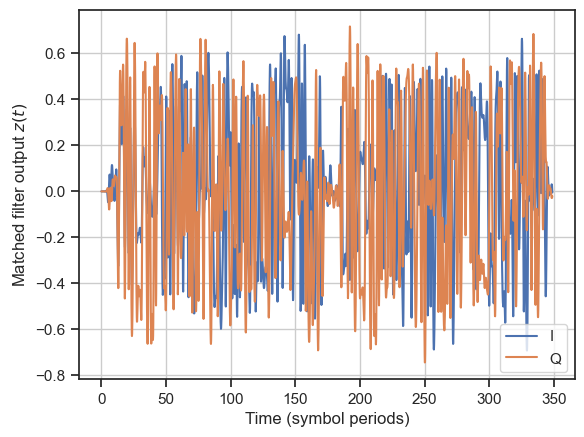

In [44]:
## plot result
tt = np.arange(len(yy))/fsT_r
plt.plot(tt, yy.real, label='I')
plt.plot(tt, yy.imag, label='Q')

plt.grid()
plt.xlabel('Time (symbol periods)')
plt.ylabel('Matched filter output $z(t)$')
plt.legend()

plt.show()

We can see a signal that shows the two bursts and is "cleaner" than the received signal - look at the noise only between bursts.

### Preamble Detection

The primary task of preamble detection is to find the location of the preamble within the received signal.

For this purpose, each phase of the matched filter outputs is correlated against the preamble sequence; this is equivalent to filtering with the time-reversed, conjugate preamble sequence.

To make the comparison to a threshold independent of scale, the squared magnitudes of the correlation values are normalized by the squared norm of the samples and also the squared norm of the preamble sequence. I.e., the decision statistic at the $n$-th matched filter output is:
$$
d[n] = \dfrac{\left| \sum_{k=0}^{K-1} r[n-(K-1)+k] \cdot p^*[k] \right|^2}
             {\sum_{k=0}^{K-1} |p[k]|^2 \cdot \sum_{k=0}^{K-1} |r[n-(K-1)+k]|^2}
$$

We could use our convolution function to compute the numerator. However, the term in the denominator involving the received signal requires the same samples of the received signal. Hence, it is more efficient to write a class that takes advantage of this observation.

In [45]:
class detector():
    "compute the normalized detector statistic"

    def __init__(self, pp):
        "constructor"
        self.pp = pp                       # preamble sequence
        self.pp_2 = np.sum(np.abs(pp)**2)  # squared norm of pp
        self.sr = np.zeros_like(pp, dtype=complex)  # shift register

    def work(self, sig):
        "compute the decision statistic"
        dd = np.zeros_like(sig, dtype=float)

        for n in range(len(sig)):
            # update the shift_register, same as for convolution
            self.sr = np.roll(self.sr, -1)  # cyclic shift to the left
            self.sr[-1] = sig[n]            # insert new sample in rightmost position

            ip = np.inner(self.sr, np.conj(self.pp))  # inner product of signal and pp
            sig_2 = np.sum(np.abs(self.sr)**2)        # squared norm of signal

            dd[n] = np.abs(ip)**2 / (self.pp_2 * sig_2)

        return dd
    
    def reset(self):
        self.sr[:] = 0

We can now combine the matched filter and the detector to compute the decision statistic for all sampling phases.

The code below expands on the code for the matched filter above and adds the computation of the detector statistic for each of the phases.

To keep track of the different phases, we instantiate a list of detector objects - one for each phase.

In [46]:
## matched filtering plus detection statistic for each phase
# instantiate a detector object for each phase
dets = [detector(pn) for n in range(fsT_r)]  # list comprehension instantiates fsT_r detectors

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of `fsT_r` samples
B = fsT_r
N_blocks = len(rr) // B
# yy = np.zeros_like(rr, shape=B*N_blocks)        # MF outputs, no longer stored
dd = np.zeros((fsT_r, N_blocks), dtype=float) # detector outputs

for n in range(N_blocks):
    start = n*B
    end = (n+1)*B
    mf_out = mf.work(rr[start:end])

    # loop over phases to compute decision statistic
    for ph in range(fsT_r):
        # pass mf_out for phase ph to corresponding detector
        # the [] around mf_out[ph] and the trailing [0] are needed because the `work`
        # expects and returns an array
        dd[ph, n] = dets[ph].work([mf_out[ph]])[0]

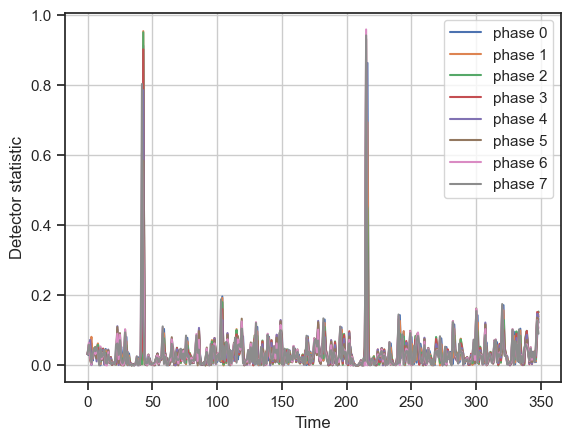

In [47]:
plt.plot(dd.T)
plt.xlabel('Time')
plt.ylabel('Detector statistic')
plt.grid()
plt.legend([f'phase {n}' for n in range(fsT_r)])

plt.show()

There are two clearly defined detection instances - one for each burst. A good threshold appears to be approximately 0.75.

### Timing estimation

The location of the maxima of the decision statistic mark the location of (the end of) the preamble. To find these locations, both block number and sampling phase, sequentially we want to find the local maximum following each time the threshold is exceeded.

An algorithm to do that sequentially is:
* initialize stored maximum value to zero
* loop over blocks:
  + loop over sampling phases:
     - set a flag the first time the threshold is exceeded 
     - if flag is set:
         * if a larger value of the decision statistic is found, update stored values
         * if a smaller value than the current maximum is encountered, declare detection at the location of the stored maximum; note that this will always be the prior input. Hence, we can simply signal that a local maximum was found. The location is simply the previous input. Also, set a flag that this maximum was detected.
     - once we drop back below, the threshold flags and the stored maximum are reset in preparation for the next search.

Clearly, this is stateful. Hence, another class is a good implementation option.

In [48]:
class time_sync():
    "find the local maximum of the decision statistic"

    def __init__(self, threshold):
        self.threshold = threshold
        self.exceeded = False
        self.detected = False
        self.curr_max = 0

    def work(self, dd):
        "check if maximum was found"
        res = False

        # mark the first time the threshold was exceeded
        if not self.exceeded and dd > self.threshold:
            self.exceeded = True

        # once threshold is exceeded, look for the local maximum
        if self.exceeded and not self.detected:
            if dd > self.curr_max:
                # update max
                self.curr_max = dd
            else:
                # starting to decline, declare previous sample the local max
                res = True
                self.detected = True

        # reset once we drop back below threshold
        if self.detected and dd < self.threshold:
            self.reset()
    
        return res
    
    def reset(self):
        self.exceeded = False
        self.detected = False
        self.curr_max = 0

As before, we add this step of the process to the sequential processing loop. The goal is to locate both of the maxima that we observed previously.

In [49]:
## matched filtering plus detection statistic for each phase plus timing estimation

# instantiate time synch object, set threshold for detector
synch = time_sync(0.75)

# instantiate a detector object for each phase
dets = [detector(pn) for n in range(fsT_r)]  # list comprehension instantiates fsT_r detectors

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of `fsT_r` samples
B = fsT_r
N_blocks = len(rr) // B
# yy = np.zeros_like(rr, shape=B*N_blocks)        # MF outputs, no longer stored
# dd = np.zeros((fsT_r, N_blocks), dtype=float) # detector outputs, no longer stored
# store the two maxima
ind_max_ph = np.zeros(2)
ind_max_sym = np.zeros(2)
val_max = np.zeros(2)
m = 0

for n in range(N_blocks):
    start = n*B
    end = (n+1)*B
    mf_out = mf.work(rr[start:end])

    # loop over phases to compute decision statistic
    for ph in range(fsT_r):
        # pass mf_out for phase ph to corresponding detector
        # the [] around mf_out[ph] and the trailing [0] are needed because the `work`
        # expects and returns an array
        dec = dets[ph].work([mf_out[ph]])[0]

        # pass decision statistic to time synch and see if local max is at prior sample
        if synch.work(dec):
            # found max, store location; don't forget that they're at the prior sample
            ind_ph = ph - 1
            ind_sym = n
            if ind_ph == -1:
                ind_ph = fsT_r - 1
                ind_sym = n - 1
            
            print(f"max at symbol {ind_sym}, phase {ind_ph}: value={synch.curr_max}")
            ind_max_ph[m] = ind_ph
            ind_max_sym[m] = ind_sym
            val_max[m] = synch.curr_max
            m = m+1
            

max at symbol 43, phase 1: value=0.9538107869939768
max at symbol 215, phase 6: value=0.9586805161820386


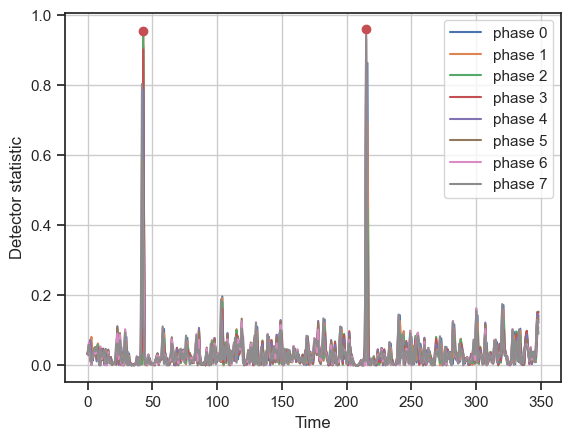

In [50]:
## mark the maxima on the plot of the decision statistic
plt.plot(dd.T)
plt.xlabel('Time')
plt.ylabel('Detector statistic')
plt.grid()
plt.legend([f'phase {n}' for n in range(fsT_r)])

plt.plot(ind_max_sym, val_max, 'ro')

plt.show()

### Estimating amplitude, phase, and frequency offset

We are nearly done with preamble processing. The only remaining task is to estimate the amplitude, phase, and frequency offset. That can be done from the matched filter outputs of the sampling phase that we just determined.

But, we don't have those samples anymore! Or do we?

Recall that the computation of the decision statistic uses a shift register that holds the matched filter outputs for each phase. The number of samples stored in those shift-registers matches the length of the preamble. 

Hence, at the time of detection we can simply pull the values we need from the shift register of the detector object for the sampling phase we need.

To verify, we augment the previous processing. At the time of detection, we plot the values in the appropriate shift register - with preamble symbols stripped off - and estimate amplitude, phase, and frequency offset.

Found max at symbol 43, phase 1: value=0.9538107869939768
	Estimated phase advance per symbol (deg):   1.2
	Estimated amplitude: 0.50
	Estimated phase at start of preamble (deg): 50.73
Found max at symbol 215, phase 6: value=0.9586805161820386
	Estimated phase advance per symbol (deg):  -1.3
	Estimated amplitude: 0.50
	Estimated phase at start of preamble (deg): 130.01


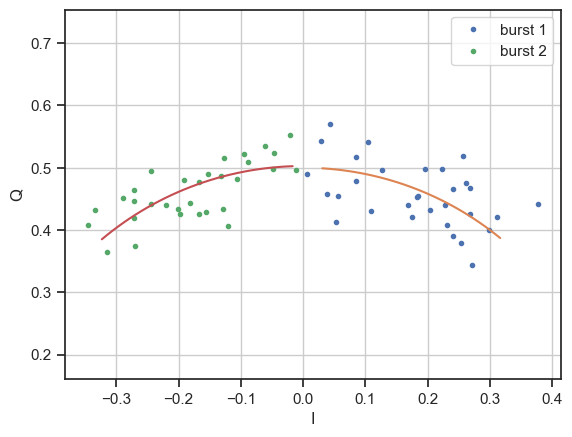

In [51]:
## matched filtering plus detection statistic for each phase plus timing estimation

# instantiate time synch object, set threshold for detector
synch = time_sync(0.75)

# instantiate a detector object for each phase
dets = [detector(pn) for n in range(fsT_r)]  # list comprehension instantiates fsT_r detectors

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of `fsT_r` samples
B = fsT_r
N_blocks = len(rr) // B
# yy = np.zeros_like(rr, shape=B*N_blocks)        # MF outputs, no longer stored
# dd = np.zeros((fsT_r, N_blocks), dtype=float) # detector outputs, no longer stored
# store the two maxima, not stored any mored
# ind_max_ph = np.zeros(2)
# ind_max_sym = np.zeros(2)
# val_max = np.zeros(2)
m = 0

for n in range(N_blocks):
    start = n*B
    end = (n+1)*B
    mf_out = mf.work(rr[start:end])

    # loop over phases to compute decision statistic
    for ph in range(fsT_r):
        # pass mf_out for phase ph to corresponding detector
        # the [] around mf_out[ph] and the trailing [0] are needed because the `work`
        # expects and returns an array
        dec = dets[ph].work([mf_out[ph]])[0]

        # pass decision statistic to time synch and see if local max is at prior sample
        if synch.work(dec):
            # found max, store location; don't forget that they're at the prior sample
            ind_ph = ph - 1
            ind_sym = n
            if ind_ph == -1:
                ind_ph = fsT_r - 1
                ind_sym = n - 1
            
            print(f"Found max at symbol {ind_sym}, phase {ind_ph}: value={synch.curr_max}")
            
            # get the matched filter outputs for the preamble from detector object and strip 
            # off the preamble symbols
            preamble_samples = dets[ind_ph].sr / pn

            # now we can find the (normalized per symbol period) frequency offset; this is the
            # phase advance per symbol in radians
            df_rad = np.angle(preamble_samples[-1]*np.conj(preamble_samples[0])) / (len(pn)-1)
            print(f"\tEstimated phase advance per symbol (deg): {df_rad * 180/np.pi:5.1f}")

            # Estimate the amplitude and phase (at the start of the preamble)
            # apply the frequency correction before taking the average
            X_hat = np.mean(preamble_samples * np.exp(-1j*df_rad*np.arange(len(pn))))
            print(f"\tEstimated amplitude: {np.abs(X_hat):4.2f}")
            print(f"\tEstimated phase at start of preamble (deg): {np.angle(X_hat) * 180/np.pi:5.2f}")

            # plot the estimated amplitude and phase together with preamble samples
            plt.plot(preamble_samples.real, preamble_samples.imag, '.', label=f"burst {m+1}")
            est_preamble = X_hat * np.exp(1j*df_rad*np.arange(len(pn)))
            plt.plot(est_preamble.real, est_preamble.imag)
            
            m = m+1

plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('equal')
plt.legend()

plt.show()

That looks good. For each of the two bursts, the preamble samples (stripped of the preamble symbols) form a cluster. The cluster is spread out due to the frequency offsets. The two lines, indicates the expected amplitude and phase based on our estimates.

The frequency offset estimate could be a little better, e.g., by considering not only the phase difference between first and last sample of the preamble.

#### Warming up the tracking loops

Everything is in place now, to initialize the tracking loops for phase and amplitude. Additionally, we can run the preamble symbols through the loops to "warm them up" for use on the information symbols.

The code below adds the tracking loops to the previous codes samples.

Burst 1: found max at symbol 43, phase 1: value=0.9538107869939768
	Estimated phase advance per symbol (deg):   1.2
	Estimated amplitude: 0.50
	Estimated phase at start of preamble (deg): 50.73
Burst 2: found max at symbol 215, phase 6: value=0.9586805161820386
	Estimated phase advance per symbol (deg):  -1.3
	Estimated amplitude: 0.50
	Estimated phase at start of preamble (deg): 130.01


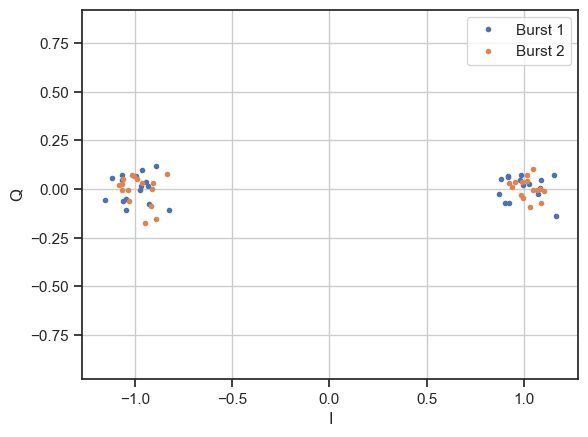

In [52]:
## matched filtering plus detection statistic for each phase plus timing estimation
## plus initialization of the tracking loops

# instantiate loop filters and integrators, one for each loop
# Parameters
alpha = 0.1     # gain for amplitude loop
alpha1 = 0.1    # gains for phase loop
alpha2 = 0.004

HA = First_Order_Filter(alpha)
SA = Integrator()

HP = Second_Order_Filter(alpha1, alpha2)
SP = Integrator()

# instantiate time synch object, set threshold for detector
synch = time_sync(0.75)

# instantiate a detector object for each phase
dets = [detector(pn) for n in range(fsT_r)]  # list comprehension instantiates fsT_r detectors

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of `fsT_r` samples
B = fsT_r
N_blocks = len(rr) // B
# yy = np.zeros_like(rr, shape=B*N_blocks)        # MF outputs, no longer stored
# dd = np.zeros((fsT_r, N_blocks), dtype=float)   # detector outputs, no longer stored
# store the two maxima, not stored any more
# ind_max_ph = np.zeros(2)
# ind_max_sym = np.zeros(2)
# val_max = np.zeros(2)
y = np.zeros(len(pn), dtype=complex) # output from tracking loops      
m = 0  # burst counter

for n in range(N_blocks):
    start = n*B
    end = (n+1)*B
    mf_out = mf.work(rr[start:end])

    # loop over phases to compute decision statistic
    for ph in range(fsT_r):
        # pass mf_out for phase ph to corresponding detector
        # the [] around mf_out[ph] and the trailing [0] are needed because the `work`
        # expects and returns an array
        dec = dets[ph].work([mf_out[ph]])[0]

        # pass decision statistic to time synch and see if local max is at prior sample
        if synch.work(dec):
            # burst detected: store location; don't forget that they're at the prior sample
            ind_ph = ph - 1
            ind_sym = n
            if ind_ph == -1:
                ind_ph = fsT_r - 1
                ind_sym = n - 1
            
            print(f"Burst {m+1}: found max at symbol {ind_sym}, phase {ind_ph}: value={synch.curr_max}")
            
            # get the matched filter outputs for the preamble from detector object and strip 
            # off the preamble symbols
            preamble_samples = dets[ind_ph].sr / pn

            # now we can find the (normalized per symbol period) frequency offset; this is the
            # phase advance per symbol in radians
            df_rad = np.angle(preamble_samples[-1]*np.conj(preamble_samples[0])) / (len(pn)-1)
            print(f"\tEstimated phase advance per symbol (deg): {df_rad * 180/np.pi:5.1f}")

            # Estimate the amplitude and phase (at the start of the preamble)
            # apply the frequency correction before taking the average
            X_hat = np.mean(preamble_samples * np.exp(-1j*df_rad*np.arange(len(pn))))
            print(f"\tEstimated amplitude: {np.abs(X_hat):4.2f}")
            print(f"\tEstimated phase at start of preamble (deg): {np.angle(X_hat) * 180/np.pi:5.2f}")

            ## warm up the tracking loops
            # initialize tracking loops
            SA.state = 1/np.abs(X_hat)  # initialize amplitude loop with 1/amplitude estimate
            SP.state = np.angle(X_hat)  # initialize phase loop with phase estimate
            HP.state = df_rad           # and frequency estimate

            # then run the preamble samples through the loops
            Z_hat = dets[ind_ph].sr
            for k in range(len(pn)):
                # first the PLL
                phi = SP.state
                x = rotate_phase(Z_hat[k], phi)        # this goes to amplitude loop
                dphi = measure_phase(x, pn[k])
                tmp = HP(dphi)
                SP(tmp)

                # then the amplitude loop, input is the phase corrected input x[n]
                gamma = SA.state
                y[k] = scale_amplitude(x, gamma)         # x is the input from above
                dA = measure_amplitude_error(y[k], pn[k])  
                tmp = HA(dA)
                SA(tmp)

            plt.plot(y.real, y.imag, '.', label=f'Burst {m+1}')
            m = m+1

plt.grid()
plt.legend()
plt.xlabel('I')
plt.ylabel('Q')
plt.axis('equal')

plt.show()

Good! We are well synchronized. For each burst, the preamble symbols form tight BPSK clusters.

All that's left to do, is demodulate the symbols following the preamble; we know that there are `Ns=128` information symbols.

Again, we expand the processing loop to add this step.

## Complete Receiver

The complete receiver loops over all symbol periods as in the code above.

It alternates between searching for the preamble and demodulation. This is tracked by a the variable `rx_state`. Switching state occurs when the preamble was found (SEARCH -> DEMOD) or when the required number of symbols was received (DEMOD -> SEARCH).

In the DEMOD state, we only need to consider the optimal sampling phase.

The code below contains the addition of the demodulation, including tracking loops, to our code.

In [53]:
## We need two states for the receiver
SEARCH = 0
DEMOD = 1

In [56]:
## Initialization and instantiation of objects
# initial state is SEARCH
rx_state = SEARCH

# instantiate loop filters and integrators, one for each loop
# Parameters
alpha = 0.1     # gain for amplitude loop
alpha1 = 0.1    # gains for phase loop
alpha2 = 0.004

HA = First_Order_Filter(alpha)
SA = Integrator()

HP = Second_Order_Filter(alpha1, alpha2)
SP = Integrator()

# instantiate time synch object, set threshold for detector
synch = time_sync(0.75)

# instantiate a detector object for each phase
dets = [detector(pn) for n in range(fsT_r)]  # list comprehension instantiates fsT_r detectors

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of `fsT_r` samples
B = fsT_r
N_blocks = len(rr) // B

est_syms = np.zeros(Ns, dtype=complex) # estimated symbols
n_syms = 0   # count demodulated symbols

m = 0  # burst counter

In [54]:
## Complete receiver

# loop over all symbol periods
for n in range(N_blocks):
    # in either state, we run samples through the matched filter
    start = n*B
    end = (n+1)*B
    mf_out = mf.work(rr[start:end])

    ### SEARCH for preamble
    if rx_state == SEARCH:
        # loop over phases to compute decision statistic
        for ph in range(fsT_r):
            # pass mf_out for phase ph to corresponding detector
            # the [] around mf_out[ph] and the trailing [0] are needed because the `work`
            # expects and returns an array
            dec = dets[ph].work([mf_out[ph]])[0]

            # pass decision statistic to time synch and see if local max is at prior sample
            if synch.work(dec):
                # burst detected: store location; don't forget that they're at the prior sample
                ind_ph = ph - 1
                ind_sym = n
                if ind_ph == -1:
                    ind_ph = fsT_r - 1
                    ind_sym = n - 1
                
                print(f"Burst {m+1}: found max at symbol {ind_sym}, phase {ind_ph}: value={synch.curr_max}")
                
                # get the matched filter outputs for the preamble from detector object and strip 
                # off the preamble symbols
                preamble_samples = dets[ind_ph].sr / pn

                # now we can find the (normalized per symbol period) frequency offset; this is the
                # phase advance per symbol in radians
                df_rad = np.angle(preamble_samples[-1]*np.conj(preamble_samples[0])) / (len(pn)-1)
                print(f"\tEstimated phase advance per symbol (deg): {df_rad * 180/np.pi:5.1f}")

                # Estimate the amplitude and phase (at the start of the preamble)
                # apply the frequency correction before taking the average
                X_hat = np.mean(preamble_samples * np.exp(-1j*df_rad*np.arange(len(pn))))
                print(f"\tEstimated amplitude: {np.abs(X_hat):4.2f}")
                print(f"\tEstimated phase at start of preamble (deg): {np.angle(X_hat) * 180/np.pi:5.2f}")

                ## warm up the tracking loops
                # initialize tracking loops
                SA.state = 1/np.abs(X_hat)  # initialize amplitude loop with 1/amplitude estimate
                SP.state = np.angle(X_hat)  # initialize phase loop with phase estimate
                HP.state = df_rad           # and frequency estimate

                # then run the preamble samples through the loops
                Z_hat = dets[ind_ph].sr
                for k in range(len(pn)):
                    # first the PLL
                    phi = SP.state
                    x = rotate_phase(Z_hat[k], phi)        # this goes to amplitude loop
                    dphi = measure_phase(x, pn[k])
                    tmp = HP(dphi)
                    SP(tmp)

                    # then the amplitude loop, input is the phase corrected input x[n]
                    gamma = SA.state
                    y = scale_amplitude(x, gamma)         # x is the input from above
                    dA = measure_amplitude_error(y, pn[k])  
                    tmp = HA(dA)
                    SA(tmp)
                
                # change state to DEMOD
                rx_state = DEMOD
                n_syms = 0

    ### demodulation
    elif rx_state == DEMOD:
        # we only process the optimal sampling phase
        # select the MF output for the correct phase
        Z_hat = mf_out[ind_ph]

        # tracking loops and decision
        # perform phase and amplitude corrections
        phi = SP.state
        x = rotate_phase(Z_hat, phi)        # this goes to amplitude loop
        gamma = SA.state
        y = scale_amplitude(x, gamma)       # this goes to the decision rule

        dec_sym = MPE_decision_rule([y], A)[0]     # symbol decision

        dphi = measure_phase(x, dec_sym)       # decision feedback
        tmp = HP(dphi)
        SP(tmp)

        # then the amplitude loop, input is the phase corrected input x[n]
        dA = measure_amplitude_error(y, dec_sym) # decision feedback 
        tmp = HA(dA)
        SA(tmp)

        # store decision, update counter
        est_syms[n_syms] = dec_sym
        n_syms += 1

        # check if we're done
        if n_syms == Ns:
            rx_state = SEARCH

            # count errors
            n_errors = np.sum(est_syms != tx_syms[m, :])
            print(f"\tFound {n_errors} symbol errors")

            # update burst counter
            m = m+1


Burst 1: found max at symbol 43, phase 1: value=0.9538107869939768
	Estimated phase advance per symbol (deg):   1.2
	Estimated amplitude: 0.50
	Estimated phase at start of preamble (deg): 50.73
	Found 0 symbol errors
Burst 2: found max at symbol 215, phase 6: value=0.9586805161820386
	Estimated phase advance per symbol (deg):  -1.3
	Estimated amplitude: 0.50
	Estimated phase at start of preamble (deg): 130.01
	Found 0 symbol errors
